In [1]:
import pandas as pd
import numpy as np

In [2]:
data2020 = pd.read_csv('2020.csv')

In [3]:
realdata2020 = data2020.iloc[0:366]

In [4]:
rs2020 = realdata2020['備轉容量(MW)'].to_frame()
rs2020 = rs2020.rename(columns={'備轉容量(MW)':'data'})

In [5]:
data2021 = pd.read_csv('2021.csv')

In [6]:
rs2021 = (data2021['備轉容量(萬瓩)'] * 10).to_frame()
rs2021 = rs2021.rename(columns={'備轉容量(萬瓩)':'data'})

In [7]:
rs = rs2020.append(rs2021)

In [8]:
print(rs.shape)

(446, 1)


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(rs)

In [10]:
train_norm = pd.DataFrame(train_norm)

In [11]:
def generate_data(train):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-38):
        X_train.append(np.array(train.iloc[i:i+30]))
        Y_train.append(np.array(train.iloc[i+30:i+38]))
    return np.array(X_train), np.array(Y_train)
# use last 30 days to predict next 8 days
X_train, Y_train = generate_data(train_norm)

In [44]:
# def shuffle(X,Y):
#     np.random.seed(10)
#     randomList = np.arange(X.shape[0])
#     np.random.shuffle(randomList)
#     return X[randomList], Y[randomList]
# # shuffle the data, and random seed is 10
# X_train, Y_train = shuffle(X_train, Y_train)

In [12]:
# import what we need for building the model
# 參考網路上lstm模型的構建方法，且暫未對模型各層級進行調整
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model

def lstm_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(30,activation='linear'))
    model.add(Dense(8,activation='linear'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error', 'accuracy'])
    model.summary()
    return model

In [13]:
model = lstm_model(X_train.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 256)           264192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             257       
_________________________________________________________________
flatten (Flatten)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 248       
Total params: 790,939
Trainable params: 790,939
Non-trainable params: 0
__________________________________________________

In [14]:
print(Y_train.shape)

(408, 8, 1)


In [15]:
Y_train = Y_train.reshape([408,8])

In [17]:
model = lstm_model(X_train.shape)
callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, Y_train, epochs=200, batch_size=5, validation_split=0.1, callbacks=[callback],shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 256)           264192    
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             257       
_________________________________________________________________
flatten_1 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 248       
Total params: 790,939
Trainable params: 790,939
Non-trainable params: 0
________________________________________________

74/74 [==============================] - 3s 44ms/step - loss: 0.1211 - mean_absolute_error: 0.1211 - accuracy: 0.1701 - val_loss: 0.0629 - val_mean_absolute_error: 0.0629 - val_accuracy: 0.0976
Epoch 36/200
74/74 [==============================] - 3s 43ms/step - loss: 0.1218 - mean_absolute_error: 0.1218 - accuracy: 0.1538 - val_loss: 0.0577 - val_mean_absolute_error: 0.0577 - val_accuracy: 0.1220
Epoch 37/200
74/74 [==============================] - 3s 42ms/step - loss: 0.1248 - mean_absolute_error: 0.1248 - accuracy: 0.1709 - val_loss: 0.0625 - val_mean_absolute_error: 0.0625 - val_accuracy: 0.1220
Epoch 38/200
74/74 [==============================] - 3s 44ms/step - loss: 0.1194 - mean_absolute_error: 0.1194 - accuracy: 0.1907 - val_loss: 0.0600 - val_mean_absolute_error: 0.0600 - val_accuracy: 0.1220
Epoch 39/200
74/74 [==============================] - 3s 42ms/step - loss: 0.1244 - mean_absolute_error: 0.1244 - accuracy: 0.1746 - val_loss: 0.0586 - val_mean_absolute_error: 0.0586 -

Epoch 75/200
74/74 [==============================] - 3s 43ms/step - loss: 0.0906 - mean_absolute_error: 0.0906 - accuracy: 0.2679 - val_loss: 0.0525 - val_mean_absolute_error: 0.0525 - val_accuracy: 0.0732
Epoch 76/200
74/74 [==============================] - 3s 42ms/step - loss: 0.0922 - mean_absolute_error: 0.0922 - accuracy: 0.2916 - val_loss: 0.0531 - val_mean_absolute_error: 0.0531 - val_accuracy: 0.1951
Epoch 77/200
74/74 [==============================] - 3s 42ms/step - loss: 0.0863 - mean_absolute_error: 0.0863 - accuracy: 0.2929 - val_loss: 0.0462 - val_mean_absolute_error: 0.0462 - val_accuracy: 0.1951
Epoch 78/200
74/74 [==============================] - 3s 43ms/step - loss: 0.0870 - mean_absolute_error: 0.0870 - accuracy: 0.3599 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518 - val_accuracy: 0.0732
Epoch 79/200
74/74 [==============================] - 3s 41ms/step - loss: 0.0818 - mean_absolute_error: 0.0818 - accuracy: 0.3220 - val_loss: 0.0562 - val_mean_absolute_er

74/74 [==============================] - 3s 43ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - accuracy: 0.7444 - val_loss: 0.0577 - val_mean_absolute_error: 0.0577 - val_accuracy: 0.0976
Epoch 115/200
74/74 [==============================] - 3s 42ms/step - loss: 0.0387 - mean_absolute_error: 0.0387 - accuracy: 0.7360 - val_loss: 0.0635 - val_mean_absolute_error: 0.0635 - val_accuracy: 0.0732
Epoch 116/200
74/74 [==============================] - 3s 43ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - accuracy: 0.7806 - val_loss: 0.0690 - val_mean_absolute_error: 0.0690 - val_accuracy: 0.0976
Epoch 117/200
74/74 [==============================] - 3s 42ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - accuracy: 0.7945 - val_loss: 0.0479 - val_mean_absolute_error: 0.0479 - val_accuracy: 0.1220
Epoch 118/200
74/74 [==============================] - 3s 45ms/step - loss: 0.0330 - mean_absolute_error: 0.0330 - accuracy: 0.7815 - val_loss: 0.0563 - val_mean_absolute_error: 0.05

74/74 [==============================] - 3s 43ms/step - loss: 0.0218 - mean_absolute_error: 0.0218 - accuracy: 0.9214 - val_loss: 0.0651 - val_mean_absolute_error: 0.0651 - val_accuracy: 0.2195
Epoch 154/200
74/74 [==============================] - 3s 43ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - accuracy: 0.8907 - val_loss: 0.0566 - val_mean_absolute_error: 0.0566 - val_accuracy: 0.0976
Epoch 155/200
74/74 [==============================] - 3s 44ms/step - loss: 0.0192 - mean_absolute_error: 0.0192 - accuracy: 0.9435 - val_loss: 0.0570 - val_mean_absolute_error: 0.0570 - val_accuracy: 0.1707
Epoch 156/200
74/74 [==============================] - 3s 44ms/step - loss: 0.0186 - mean_absolute_error: 0.0186 - accuracy: 0.9258 - val_loss: 0.0604 - val_mean_absolute_error: 0.0604 - val_accuracy: 0.1220
Epoch 157/200
74/74 [==============================] - 3s 42ms/step - loss: 0.0199 - mean_absolute_error: 0.0199 - accuracy: 0.9239 - val_loss: 0.0671 - val_mean_absolute_error: 0.06

In [21]:
model.save('my_model.h5')

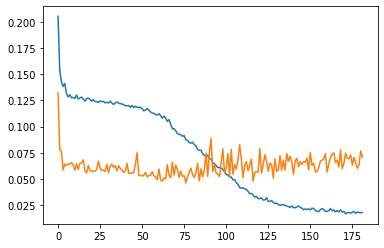

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [19]:
print(train_norm.shape)

(446, 1)


In [20]:
Predict1 = model.predict(np.array(train_norm[416:446]).reshape((1,30,1)))
print(Predict1)
trainPredict = scaler.inverse_transform(Predict1)
print(trainPredict)

[[0.19958693 0.24699923 0.21507698 0.17275988 0.1231887  0.18758735
  0.13288654 0.10224235]]
[[3206.8372 3340.3027 3250.4417 3131.3188 2991.7761 3173.0583 3019.0757
  2932.8123]]


In [15]:
model = load_model('my_model.h5')

In [24]:
result = model.predict(np.array(train_norm[416:446]).reshape((1,30,1)))
print(result)
real_result = scaler.inverse_transform(result)
print(real_result)

[[0.19958693 0.24699923 0.21507698 0.17275988 0.1231887  0.18758735
  0.13288654 0.10224235]]
[[3206.8372 3340.3027 3250.4417 3131.3188 2991.7761 3173.0583 3019.0757
  2932.8123]]


In [25]:
real_result[0][1]

3340.3027

In [26]:
f = open('submission.csv', 'w')
print("date,operating_reserve(MW)", file=f)
for i in range(1, 7):
    print(f"2021032{i+2},{int(real_result[0][i])}", file=f)
print(f"20210329,{int(real_result[0][7])}", file=f, end="")

In [27]:
f.close()